In [ ]:
#!/usr/bin/env python
# coding: utf-8
import numpy as np 
import networkx as nx
import matplotlib.pyplot as plt
import random
import argparse
import os
import time
import sqlite3
import os
import glob
import json
import time
import multiprocessing
import pandas as pd
from itertools import combinations
from collections import Counter


def read_dimacs(filename): # int num_vars, array clauses
    clauses = []
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith('p'):
                parts = line.strip().split()
                if len(parts) >= 4:
                    _, _, variables, _ = parts[:4]
                    num_vars = int(variables)
                else:
                    raise ValueError("Invalid CNF file format in 'p' line.")
            elif line.startswith('c') or line.startswith('%') or line.startswith('0'):
                continue
            else:
                clause = list(map(int, line.strip().split()))
                # Remove the trailing 0 if present
                if clause and clause[-1] == 0:
                    clause = clause[:-1]
                if clause:
                    clauses.append(clause)
    return num_vars, clauses

def extract_problem_number(filename) -> int:
    """Extract numerical problem number from filename."""
    basename = os.path.basename(filename)
    num_str = ''.join(filter(str.isdigit, basename)) # jank the digits
    return int(num_str)


def walkSAT(clauses, max_tries, max_flips, p): # assignment, _Tries, _Flips, flips
    flips = 0
    def evaluate_clause(clause, assignment):
        return any((var > 0 and assignment.get(abs(var), False)) or 
                   (var < 0 and not assignment.get(abs(var), False)) for var in clause)

    def get_unsatisfied_clauses(clauses, assignment):
        return [clause for clause in clauses if not evaluate_clause(clause, assignment)]

    def get_variables(clauses):
        return set(abs(var) for clause in clauses for var in clause)

    def flip_variable(assignment, var):
        assignment[var] = not assignment[var]

    for _Tries in range(max_tries):
        variables = list(get_variables(clauses))
        assignment = {var: random.choice([True, False]) for var in variables}
        
        for _Flips in range(max_flips):

            unsatisfied = get_unsatisfied_clauses(clauses, assignment)
            if not unsatisfied:
                return assignment, _Tries, _Flips, flips  # Found a satisfying assignment
            
            clause = random.choice(unsatisfied)
            if random.random() < p:
                # Flip a random variable from the clause
                var_to_flip = abs(random.choice(clause))
            else:
                # Flip a variable that minimizes the number of unsatisfied clauses if flipped
                break_counts = []
                for var in clause:
                    assignment[abs(var)] = not assignment[abs(var)]
                    break_counts.append((len(get_unsatisfied_clauses(clauses, assignment)), abs(var)))
                    assignment[abs(var)] = not assignment[abs(var)]  # Undo the flip
                
                min_break = min(break_counts, key=lambda x: x[0])
                vars_with_min_break = [var for break_count, var in break_counts if break_count == min_break[0]]
                var_to_flip = random.choice(vars_with_min_break)
            
            flip_variable(assignment, var_to_flip)
            flips += 1

    return "FAIL"

from itertools import combinations

def evaluate_clause(clause, assignment):
    return any(
        (var > 0 and assignment.get(abs(var), False)) or
        (var < 0 and not assignment.get(abs(var), False))
        for var in clause
    )

def get_unsatisfied_clauses(clauses, assignment):
    return [clause for clause in clauses if not evaluate_clause(clause, assignment)]

def get_variables(clauses):
    return set(abs(var) for clause in clauses for var in clause)

def flip_variable(assignment, var):
    assignment[var] = not assignment[var]

def GenerateColors(clauses):
    variables = set(abs(literal) for clause in clauses for literal in clause)
    G = nx.Graph()
    G.add_nodes_from(variables)  # Variable adjacency graph

    # If variables appear in the same clause, make an edge
    for clause in clauses:
        vars_in_clause = set(abs(literal) for literal in clause)
        for var1, var2 in combinations(vars_in_clause, 2):
            G.add_edge(var1, var2)

    # Greedy coloring , return dictionary of unique colors (0 to n) for each node
    colors = nx.coloring.greedy_color(G, strategy='largest_first')
    return colors

def process_clause(clause, assignment, clauses, p, color_array):
    variables_in_clause = np.abs(np.array(clause, dtype=int))
    break_counts = []

    # Line 6) Calculate set of break values for all unsat C
    for x in variables_in_clause:
        assignment[x] = ~assignment[x]
        num_new_unsat = 0
        for clause_check in clauses:
            literals_check = np.array(clause_check, dtype=int)
            vars_in_clause_check = np.abs(literals_check).astype(int)
            signs_check = literals_check > 0
            clause_values_check = assignment[vars_in_clause_check]
            clause_evaluation_check = np.where(signs_check, clause_values_check, ~clause_values_check)
            if not np.any(clause_evaluation_check):
                num_new_unsat += 1
        break_counts.append(num_new_unsat)
        assignment[x] = ~assignment[x]

    candidate_list_of_variables = set() # avoid repeats
    if 0 in break_counts:
        freebie = variables_in_clause[break_counts.index(0)]
        candidate_list_of_variables.add((freebie, color_array[freebie]))

    # Pick a random variable or the min-break variable based on p
    if random.random() < p:
        x = np.random.choice(variables_in_clause)
    else:
        min_break = np.min(break_counts)
        min_indices = np.where(break_counts == min_break)[0]
        idx_min = np.random.choice(min_indices)
        x = variables_in_clause[idx_min]
    candidate_list_of_variables.add((x, color_array[x]))
    candidate_list_of_variables = list(candidate_list_of_variables)
    return candidate_list_of_variables

# Algorithm A1 Steps (v2):
# Modified Jan 22 2025
# with VIPSat color iteration ideas
import concurrent.futures
from itertools import cycle
def AlgorithmA1(clauses, colors, max_tries, max_flips, p, heuristic_mode=0):
    """    
    clauses: array of clauses from read_cnf() 
    colors: dictionary of color memberships from GenerateColors()
    max_tries: integer of max restarts for algorithm
    max_flips: integer of iterations of algorithm for a given try
    p: probability of greedy vs random selection
    heuristic_mode: 
        0 = greedy in colors from candidate variables to flip
        1 = random from candidate variables to flip
        2 = pick a random color from candidate variables to flip
        3 = always pick first candidate variable in the candidate variables to flip
        4 = Iterate colors in a cycle that is always RGBRGBRGB ... for (RGB) unique colors
    """
    color_choice_history = [] # needed this to track how heuristic choices impact the convergence
    flips = 0
    variables = np.array(sorted(get_variables(clauses))) # Sorted list of variables
    # 1-based indexing, because 0 in cnf files is used for line breaks
    num_vars = variables[-1]
    color_array = np.zeros(num_vars + 1, dtype=int)
    for var, color in colors.items():
        color_array[var] = color
    unique_colors = np.unique(color_array[color_array > 0]) # number of unique colors
    color_cycle = cycle(unique_colors)
    for _try in range(max_tries):
        # Line 2) Random assignment
        assignment = np.random.choice([True, False], size=num_vars + 1)  # 1 based indexing

        for _flip in range(max_flips):
            # Line 5.a) Gather indeces of UNSAT clauses
            unsat_indices = []
            for idx, clause in enumerate(clauses):
                literals = np.array(clause, dtype=int)
                vars_in_clause = np.abs(literals).astype(int)
                signs = literals > 0
                clause_values = assignment[vars_in_clause]  # Get assignment values
                clause_evaluation = np.where(signs, clause_values, ~clause_values)
                # If none evaluate to 1, add to unsat index
                if not np.any(clause_evaluation):
                    unsat_indices.append(idx)

            if not unsat_indices: # Line 4) If assignment is a solution, return True
                return assignment[1:], _try, _flip, flips, color_choice_history #_flip is iteration count, flips is actual flips

            # Line 5.b) Gather UNSAT clauses
            selected_clauses = [clauses[i] for i in unsat_indices]
            candidate_list_of_variables = []

            with concurrent.futures.ThreadPoolExecutor() as executor: # Line 5) Should be in parallel.
                futures = []
                for clause in selected_clauses:
                    # Use assignment.copy() if you need to avoid concurrent mutation
                    # or in EE/HW terms: to avoid race conditions.
                    futures.append(
                        executor.submit(process_clause, clause, assignment.copy(),
                                        clauses, p, color_array)
                    )

                for future in concurrent.futures.as_completed(futures):
                    candidate_list_of_variables.extend(future.result())

            # Line 13) Prepare the candidate list of variables for heuristics
            color_to_candidates = {}
            for x, color in candidate_list_of_variables:
                color_to_candidates.setdefault(color, []).append(x)

            # Line 14) Flip all variables of color B based on heuristics:
            # 1/4/25 added color tracking
            # 1/23/25 added extra heuristic and made assignments pedantic 
            if heuristic_mode == 0:
                # 5a) Flip variables of the color with the largest number of variables
                selected_color = max(color_to_candidates.keys(), key=lambda c: len(color_to_candidates[c]))
                candidates_in_color = color_to_candidates[selected_color]
                candidates_in_color = set(candidates_in_color) # remove duplicates just in case, but my code handles them fine
                candidates_in_color = list(candidates_in_color)
                assignment[candidates_in_color] = ~assignment[candidates_in_color]
                flips += len(candidates_in_color)
                color_choice_history.append({"color": selected_color, "flips": len(candidates_in_color)})
            elif heuristic_mode == 1:
                # 5b) Randomly pick a variable from candidate variables to flip
                var_to_flip = np.random.choice([x for x, _ in candidate_list_of_variables])
                assignment[var_to_flip] = ~assignment[var_to_flip]
                flips += 1
                color_choice_history.append({"color": color_array[var_to_flip], "flips": 1})
            elif heuristic_mode == 2:
                # 5c) Randomly pick a color, flip all variables of that color
                selected_color = np.random.choice(list(color_to_candidates.keys()))
                candidates_in_color = color_to_candidates[selected_color]
                candidates_in_color = set(candidates_in_color) # remove duplicates just in case, but my code handles them fine
                candidates_in_color = list(candidates_in_color)
                assignment[candidates_in_color] = ~assignment[candidates_in_color]
                flips += len(candidates_in_color)
                color_choice_history.append({"color": selected_color, "flips": len(candidates_in_color)})
            elif heuristic_mode == 3:
                # 5d) Always pick the first candidate variable to flip
                var_to_flip = candidate_list_of_variables[0][0]
                assignment[var_to_flip] = ~assignment[var_to_flip]
                flips += 1
                color_choice_history.append({"color": color_array[var_to_flip], "flips": 1})
            elif heuristic_mode == 4:
                # 5e) VIP-SAT idea: just go RGBRGBRGB and discard if you do not flip 
                selected_color = next(color_cycle)
                try:                
                    candidates_in_color = color_to_candidates[selected_color]
                    candidates_in_color = set(candidates_in_color) # remove duplicates just in case
                    candidates_in_color = list(candidates_in_color)
                    assignment[candidates_in_color] = ~assignment[candidates_in_color]
                    flips += len(candidates_in_color)
                    color_choice_history.append({"color": selected_color, "flips": len(candidates_in_color)})
                except:
                    # If you do not do anything then do not log anything
                    color_choice_history.append({"color": None, "flips": None})


    return "FAIL"
def save_to_csv(results, csv_file_path):
    """Save results to CSV file"""
    # Create dataframe
    columns = ['run_id', 'problem_name', 'time_to_solution', 'noise_param', 
               'tries', 'iterations', 'flips', 'order_of_colors', 'order_of_parallel_flips']
    
    df = pd.DataFrame(results, columns=columns[1:])  # Exclude run_id for now
    df.insert(0, 'run_id', range(1, len(results) + 1))  # Add run_id column
    
    # Check if file exists to determine if we need headers
    file_exists = os.path.isfile(csv_file_path)
    
    # Write to CSV
    if file_exists:
        # Append without writing headers
        df.to_csv(csv_file_path, mode='a', header=False, index=False)
    else:
        # Create new file with headers
        df.to_csv(csv_file_path, index=False)
    
    return df

In [2]:
import os
import glob
import time
import random
from multiprocessing import Process, Queue, current_process

# Simple replica with message passing to main function
# Spawn 4 processes to run wsat() on a single problem
# if any of them finishes the job, terminate the stragglers
# return the solution

def process_file_message_passing(cnf_file, msg_queue):
    chosen_max_tries = 1
    max_flips_var = 10000 
    noise_value = 0.5
    problem_name = os.path.basename(cnf_file)
    _, clauses = read_dimacs(cnf_file)
    start = time.perf_counter()
    solution_object = walkSAT(clauses, max_tries=chosen_max_tries,
                              max_flips=max_flips_var, p=noise_value)
    end = time.perf_counter()

    if solution_object != "FAIL":
        time_to_solution = end - start
        assignment, tries, iterations, flips = solution_object
        result = (problem_name, time_to_solution, noise_value, tries, iterations, flips)
    else:
        result = (problem_name, None, None, None, None, None)
    msg_queue.put((current_process().name, result))


# Managers provide a way to create data which can be shared between different processes, 
# including sharing over a network between processes running on different machines. 
# A manager object controls a server process which manages shared objects. 
# Other processes can access the shared objects by using proxies.

def message_passing():
    NUMBER_OF_PROCESSES_PER_PROBLEM = 4

    # CHANGEME 
    cnf_directory = "/home/dae/SatExperiments/ColoringWalksatExperiments/TestFolderCNF"
    cnf_files = glob.glob(os.path.join(cnf_directory, "uf50*.cnf"))
    cnf_files.sort(key=lambda f: int(''.join(filter(str.isdigit, f)) or 0))

    for cnf_file in cnf_files:
        message_queue = Queue()
        processes = []
        for _ in range(NUMBER_OF_PROCESSES_PER_PROBLEM):
            p = Process(target=process_file_message_passing, args=(cnf_file, message_queue))
            p.start()
            processes.append(p)
        # Collect the first result produced by any of the processes.
        proc_name, result = message_queue.get()
        print(f"First result for {cnf_file} from {proc_name}: {result}")
        # Terminate remaining processes if only one result is needed.
        for p in processes:
            p.terminate()
        for p in processes:
            p.join()
        return (proc_name, result)

if __name__ == '__main__':

    a = []
    for i in range(1):
        res = message_passing()
        a.append(res)
        

First result for /home/dae/SatExperiments/ColoringWalksatExperiments/TestFolderCNF/uf5004.cnf from Process-3: ('uf5004.cnf', 0.05143309093546122, 0.5, 0, 269, 269)
First result for /home/dae/SatExperiments/ColoringWalksatExperiments/TestFolderCNF/uf5004.cnf from Process-8: ('uf5004.cnf', 0.2612282660556957, 0.5, 0, 1359, 1359)
First result for /home/dae/SatExperiments/ColoringWalksatExperiments/TestFolderCNF/uf5004.cnf from Process-10: ('uf5004.cnf', 0.031995118013583124, 0.5, 0, 147, 147)
First result for /home/dae/SatExperiments/ColoringWalksatExperiments/TestFolderCNF/uf5004.cnf from Process-15: ('uf5004.cnf', 0.0217340390663594, 0.5, 0, 92, 92)
First result for /home/dae/SatExperiments/ColoringWalksatExperiments/TestFolderCNF/uf5004.cnf from Process-19: ('uf5004.cnf', 0.009511155891232193, 0.5, 0, 50, 50)
First result for /home/dae/SatExperiments/ColoringWalksatExperiments/TestFolderCNF/uf5004.cnf from Process-21: ('uf5004.cnf', 0.012968385010026395, 0.5, 0, 71, 71)
First result fo

KeyboardInterrupt: 

In [3]:
# Modified the WSAT routine to have a broadcast queue and an unsat treshhold
# Basically, if any of the solvers is X clauses away from solving the problem
# Restart the phase of all of them to match the one which is closest by broadcasting
# the phase of the closest one to be solving it.

def BroadcastingWalkSAT(clauses, max_tries, max_flips, p, broadcast_queues=None, unsat_threshold=10): # assignment, _Tries, _Flips, flips, broadcast queue, unsat_clause_number_threshold
    flips = 0
    def evaluate_clause(clause, assignment):
        return any((var > 0 and assignment.get(abs(var), False)) or 
                   (var < 0 and not assignment.get(abs(var), False)) for var in clause)

    def get_unsatisfied_clauses(clauses, assignment):
        return [clause for clause in clauses if not evaluate_clause(clause, assignment)]

    def get_variables(clauses):
        return set(abs(var) for clause in clauses for var in clause)

    def flip_variable(assignment, var):
        assignment[var] = not assignment[var]

    for _Tries in range(max_tries):
        variables = list(get_variables(clauses))
        assignment = {var: random.choice([True, False]) for var in variables}
        
        for _Flips in range(max_flips):

            unsatisfied = get_unsatisfied_clauses(clauses, assignment)
            if not unsatisfied:
                return assignment, _Tries, _Flips, flips  # Found a satisfying assignment
            
            if broadcast_queues is not None and len(unsatisfied) < unsat_threshold:
                for bq in broadcast_queues:
                    bq.put(assignment.copy())

            clause = random.choice(unsatisfied)
            if random.random() < p:
                # Flip a random variable from the clause
                var_to_flip = abs(random.choice(clause))
            else:
                # Flip a variable that minimizes the number of unsatisfied clauses if flipped
                break_counts = []
                for var in clause:
                    assignment[abs(var)] = not assignment[abs(var)]
                    break_counts.append((len(get_unsatisfied_clauses(clauses, assignment)), abs(var)))
                    assignment[abs(var)] = not assignment[abs(var)]  # Undo the flip
                
                min_break = min(break_counts, key=lambda x: x[0])
                vars_with_min_break = [var for break_count, var in break_counts if break_count == min_break[0]]
                var_to_flip = random.choice(vars_with_min_break)
            
            flip_variable(assignment, var_to_flip)
            flips += 1

    return "FAIL"

In [ ]:
import os
import glob
import time
import random
import queue
import threading
import pandas as pd
import csv
from multiprocessing import Process, Queue, Manager, current_process

def worker_broadcast_WSAT(cnf_file, message_queue, broadcast_queue, broadcast_queues, internal_data, unsat_threshold):
    def poll_broadcast():
        # This thread polls the worker's broadcast queue and updates internal_data
        while True:
            try:
                new_assignment = broadcast_queue.get(timeout=0.1)
                internal_data.update(new_assignment)
                print(f"{current_process().name} updated internal data: {new_assignment}")
            except queue.Empty:
                continue
    
    poll_thread = threading.Thread(target=poll_broadcast, daemon=True)  # spawn a thread to just look
    # for broadcast signals
    poll_thread.start()
    
    chosen_max_tries = 1
    max_flips_var = 10000
    noise_value = 0.5
    problem_name = os.path.basename(cnf_file)
    
    # Fix the read_dimacs function call
    _, clauses = read_dimacs(cnf_file)
    
    start = time.perf_counter()
    solution_object = BroadcastingWalkSAT(clauses, max_tries=chosen_max_tries,
                              max_flips=max_flips_var, p=noise_value,
                              broadcast_queues=broadcast_queues,
                              unsat_threshold=unsat_threshold)
    end = time.perf_counter()
    
    if solution_object != "FAIL":
        time_to_solution = end - start
        assignment, tries, iterations, flips = solution_object
        result = (problem_name, time_to_solution, noise_value, tries, iterations, flips, 
                 assignment.get('order_of_colors', None), assignment.get('order_of_parallel_flips', None))
    else:
        result = (problem_name, None, None, None, None, None, None, None)
    
    message_queue.put((current_process().name, result))

def message_passing():
    NUMBER_OF_PROCESSES_PER_PROBLEM = 4
    unsat_threshold = 10  # Broadcast threshold
    cnf_directory = "/home/dae/SatExperiments/ColoringWalksatExperiments/TestFolderCNF"
    cnf_files = glob.glob(os.path.join(cnf_directory, "uf50*.cnf"))
    cnf_files.sort(key=lambda f: int(''.join(filter(str.isdigit, f)) or 0))
    
    manager = Manager()
    
    for cnf_file in cnf_files:
        message_queue = Queue()
        broadcast_queues = []  # One broadcast queue per worker
        processes = []
        # Shared dictionary for workers to update when they get a broadcast
        internal_data = manager.dict()
        
        for _ in range(NUMBER_OF_PROCESSES_PER_PROBLEM):
            bq = Queue()
            broadcast_queues.append(bq)
            
        # Up to n_processes workers per CNF file
        for i in range(NUMBER_OF_PROCESSES_PER_PROBLEM):
            p = Process(target=worker_broadcast_WSAT,
                        args=(cnf_file, message_queue, broadcast_queues[i],
                              broadcast_queues, internal_data, unsat_threshold))
            p.start()
            processes.append(p)
            
        # Collect the first result produced by any worker (first SAT is our result)
        proc_name, result = message_queue.get()
        print(f"First result for {cnf_file} from {proc_name}: {result}")
        
        # Then kill the processes
        for p in processes:
            p.terminate()
        for p in processes:
            p.join()
            
        return result

if __name__ == '__main__':
    # CHANGEME File path
    output_csv = "replica2025Feb25Results.csv"
    results = []
    num_experiments = 100
    
    for i in range(num_experiments):
        if i % 10 == 0: 
            print(f"Running experiment {i+1}/{num_experiments}")
            
        result = message_passing()
        results.append(result)
        
        # Save intermediate results every 100 iterations
        if (i + 1) % 100 == 0:
            temp_df = save_to_csv(results, output_csv)
            results = []  # Clear results list after saving
            print(f"Saved results to {output_csv}")
            print(temp_df.head())
            
    # Save any remaining results
    if results:
        final_df = save_to_csv(results, output_csv)
        
    # Load and display the full dataset
    full_df = pd.read_csv(output_csv)
    print("\nFinal dataset:")
    print(full_df.head())
    print(full_df.info())

Running experiment 1/100
Process-4199 updated internal data: {1: False, 2: True, 3: False, 4: False, 5: False, 6: False, 7: False, 8: True, 9: True, 10: False, 11: False, 12: True, 13: True, 14: True, 15: True, 16: False, 17: True, 18: False, 19: False, 20: True, 21: False, 22: False, 23: False, 24: False, 25: False, 26: False, 27: True, 28: True, 29: False, 30: True, 31: True, 32: True, 33: True, 34: True, 35: True, 36: True, 37: True, 38: True, 39: True, 40: False, 41: False, 42: False, 43: False, 44: True, 45: True, 46: False, 47: False, 48: False, 49: False, 50: False}
Process-4198 updated internal data: {1: False, 2: True, 3: False, 4: False, 5: False, 6: False, 7: False, 8: True, 9: True, 10: False, 11: False, 12: True, 13: True, 14: True, 15: True, 16: False, 17: True, 18: False, 19: False, 20: True, 21: False, 22: False, 23: False, 24: False, 25: False, 26: False, 27: True, 28: True, 29: False, 30: True, 31: True, 32: True, 33: True, 34: True, 35: True, 36: True, 37: True, 38: 

In [ ]:
import os
import glob
import time
import random
from multiprocessing import Process, Queue, current_process

# Replica with message passing, but now for the
# A1 algorithm, the general idea is that the independent threads do not 
# talk to each other ; assuming A1 can still eval as many UNSAT clauses as it 
# wishes on every Task 5 spawn.

def process_file_message_passing_A1(cnf_file, msg_queue):
    chosen_max_tries = 1
    max_flips_var = 10000 
    noise_value = 0.5
    problem_name = os.path.basename(cnf_file)
    _, clauses = read_dimacs(cnf_file)
    start = time.perf_counter()
    colors = GenerateColors(clauses)
    solution_object = AlgorithmA1(clauses, colors, max_tries=chosen_max_tries,
                                   max_flips=max_flips_var, p=noise_value, heuristic_mode=0)
    end = time.perf_counter()
    if solution_object != "FAIL":
        time_to_solution = end - start
        assignment, tries, iterations, flips, color_order = solution_object
        colors_order_iter = [entry["color"] for entry in color_order]
        flips_iter = [entry["flips"] for entry in color_order] 
        result = (problem_name, time_to_solution, noise_value, tries, iterations, flips, colors_order_iter, flips_iter)
    else:
        result = (problem_name, None, None, None, None, None, None, None)
    msg_queue.put((current_process().name, result))

def message_passing_A1():
    NUMBER_OF_PROCESSES_PER_PROBLEM = 4

    # CHANGEME 
    cnf_directory = "/home/dae/SatExperiments/ColoringWalksatExperiments/TestFolderCNF"
    cnf_files = glob.glob(os.path.join(cnf_directory, "uf50*.cnf"))
    cnf_files.sort(key=lambda f: int(''.join(filter(str.isdigit, f)) or 0))

    for cnf_file in cnf_files:
        message_queue = Queue()
        processes = []
        for _ in range(NUMBER_OF_PROCESSES_PER_PROBLEM):
            p = Process(target=process_file_message_passing_A1, args=(cnf_file, message_queue))
            p.start()
            processes.append(p)
        # Collect the first result produced by any of the processes.
        proc_name, result = message_queue.get()
        print(f"First result for {cnf_file} from {proc_name}: {result}")
        # Terminate remaining processes if only one result is needed.
        for p in processes:
            p.terminate()
        for p in processes:
            p.join()
        return result


def save_to_csv_A1(results, csv_file_path):
    """Save results to CSV file"""
    # Create dataframe
    columns = ['run_id', 'problem_name', 'time_to_solution', 'noise_param', 
               'tries', 'iterations', 'flips', 'order_of_colors', 'order_of_parallel_flips']
    
    df = pd.DataFrame(results, columns=columns[1:])  # Exclude run_id for now
    df.insert(0, 'run_id', range(1, len(results) + 1))  # Add run_id column
    
    file_exists = os.path.isfile(csv_file_path)
        
    if file_exists:
        # Append without writing headers
        df.to_csv(csv_file_path, mode='a', header=False, index=False)
    else:
        # Create new file with headers
        df.to_csv(csv_file_path, index=False)
    
    return df



if __name__ == '__main__':
    # CHANGEME File path
    output_csv = "replicaA1_2025Feb25Results.csv"
    results = []
    num_experiments = 10
    
    for i in range(num_experiments):
            
        result = message_passing_A1()
        results.append(result)
        
        # Save intermediate results every 100 iterations
        if (i + 1) % 100 == 0:
            temp_df = save_to_csv_A1(results, output_csv)
            results = []  # Clear results list after saving
            print(f"Saved results to {output_csv}")
            print(temp_df.head())
            
    # Save any remaining results
    if results:
        final_df = save_to_csv_A1(results, output_csv)
        
    # Load and display the full dataset
    full_df = pd.read_csv(output_csv)
    print("\nFinal dataset:")
    print(full_df.head())
    print(full_df.info())
        

Running experiment 1/10
First result for /home/dae/SatExperiments/ColoringWalksatExperiments/TestFolderCNF/uf5004.cnf from Process-5125: ('uf5004.cnf', 4.434300999040715, 0.5, 0, 286, 313, [6, 8, 3, 6, 3, 0, 2, 3, 7, 3, 8, 5, 4, 5, 8, 8, 4, 6, 0, 3, 2, 5, 4, 0, 7, 0, 0, 0, 5, 5, 0, 6, 6, 0, 0, 0, 4, 4, 4, 0, 0, 0, 0, 4, 4, 2, 2, 4, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 4, 2, 2, 4, 4, 4, 4, 4, 5, 0, 7, 7, 5, 4, 4, 4, 0, 4, 7, 0, 0, 4, 3, 3, 0, 4, 4, 4, 5, 5, 0, 6, 7, 6, 0, 5, 5, 0, 8, 3, 8, 6, 6, 6, 8, 8, 8, 2, 1, 6, 6, 2, 1, 8, 0, 4, 4, 4, 4, 4, 4, 4, 4, 0, 8, 1, 1, 8, 8, 8, 8, 8, 0, 5, 5, 0, 6, 6, 8, 8, 0, 5, 6, 6, 5, 5, 5, 4, 2, 2, 0, 0, 2, 2, 0, 0, 0, 3, 7, 3, 3, 3, 6, 6, 0, 4, 5, 5, 4, 4, 5, 6, 5, 5, 6, 7, 7, 7, 7, 5, 5, 5, 5, 5, 4, 4, 5, 7, 7, 7, 7, 5, 4, 0, 0, 4, 5, 5, 4, 4, 4, 4, 0, 6, 7, 6, 0, 0, 8, 1, 1, 1, 1, 8, 0, 5, 5, 0, 6, 6, 0, 0, 0, 0, 0, 5, 5, 0, 6, 6, 8, 1, 1, 2, 2, 8, 8, 8, 0, 4, 4, 0, 8, 8, 6, 6, 0, 5, 7, 7, 5, 4, 2, 2, 0, 0, 4, 0, 8, 8, 6, 8, 8, 6, 0, 0, 6, 6, 0, 5, 5, 0, 

In [ ]:
# Algorithm A1 Steps (v2):
# Modified February 26 2025
# Now adding message passing / broadcast steps
import concurrent.futures
from itertools import cycle

# General idea: implement a message passing heuristic between parallel replicas.
# Also, this gives us one more point of comparison to just runnning 4 copies of A1 at the same time...

def BroadcastingAlgorithmA1(clauses, colors, max_tries, max_flips, p, heuristic_mode=0, unsat_threshold=10):
    """    
    clauses: array of clauses from read_cnf() 
    colors: dictionary of color memberships from GenerateColors()
    max_tries: integer of max restarts for algorithm
    max_flips: integer of iterations of algorithm for a given try
    p: probability of greedy vs random selection
    heuristic_mode: 
        0 = greedy in colors from candidate variables to flip
        1 = random from candidate variables to flip
        2 = pick a random color from candidate variables to flip
        3 = always pick first candidate variable in the candidate variables to flip
        4 = Iterate colors in a cycle that is always RGBRGBRGB ... for (RGB) unique colors
    """
    color_choice_history = [] # needed this to track how heuristic choices impact the convergence
    flips = 0
    variables = np.array(sorted(get_variables(clauses))) # Sorted list of variables
    # 1-based indexing, because 0 in cnf files is used for line breaks
    num_vars = variables[-1]
    color_array = np.zeros(num_vars + 1, dtype=int)
    for var, color in colors.items():
        color_array[var] = color
    unique_colors = np.unique(color_array[color_array > 0]) # number of unique colors
    color_cycle = cycle(unique_colors)
    for _try in range(max_tries):
        # Line 2) Random assignment
        assignment = np.random.choice([True, False], size=num_vars + 1)  # 1 based indexing

        for _flip in range(max_flips):
            # Line 5.a) Gather indeces of UNSAT clauses
            unsat_indices = []
            for idx, clause in enumerate(clauses):
                literals = np.array(clause, dtype=int)
                vars_in_clause = np.abs(literals).astype(int)
                signs = literals > 0
                clause_values = assignment[vars_in_clause]  # Get assignment values
                clause_evaluation = np.where(signs, clause_values, ~clause_values)
                # If none evaluate to 1, add to unsat index
                if not np.any(clause_evaluation):
                    unsat_indices.append(idx)

            if not unsat_indices: # Line 4) If assignment is a solution, return True
                return assignment[1:], _try, _flip, flips, color_choice_history #_flip is iteration count, flips is actual flips

            # Line 5.b) Gather UNSAT clauses
            selected_clauses = [clauses[i] for i in unsat_indices]
            candidate_list_of_variables = []

            with concurrent.futures.ThreadPoolExecutor() as executor: # Line 5) Should be in parallel.
                futures = []
                for clause in selected_clauses:
                    # Use assignment.copy() if you need to avoid concurrent mutation
                    # or in EE/HW terms: to avoid race conditions.
                    futures.append(
                        executor.submit(process_clause, clause, assignment.copy(),
                                        clauses, p, color_array)
                    )

                for future in concurrent.futures.as_completed(futures):
                    candidate_list_of_variables.extend(future.result())

            # Line 13) Prepare the candidate list of variables for heuristics
            color_to_candidates = {}
            for x, color in candidate_list_of_variables:
                color_to_candidates.setdefault(color, []).append(x)

            # Line 14) Flip all variables of color B based on heuristics:
            # 1/4/25 added color tracking
            # 1/23/25 added extra heuristic and made assignments pedantic 
            if heuristic_mode == 0:
                # 5a) Flip variables of the color with the largest number of variables
                selected_color = max(color_to_candidates.keys(), key=lambda c: len(color_to_candidates[c]))
                candidates_in_color = color_to_candidates[selected_color]
                candidates_in_color = set(candidates_in_color) # remove duplicates just in case, but my code handles them fine
                candidates_in_color = list(candidates_in_color)
                assignment[candidates_in_color] = ~assignment[candidates_in_color]
                flips += len(candidates_in_color)
                color_choice_history.append({"color": selected_color, "flips": len(candidates_in_color)})
            elif heuristic_mode == 1:
                # 5b) Randomly pick a variable from candidate variables to flip
                var_to_flip = np.random.choice([x for x, _ in candidate_list_of_variables])
                assignment[var_to_flip] = ~assignment[var_to_flip]
                flips += 1
                color_choice_history.append({"color": color_array[var_to_flip], "flips": 1})
            elif heuristic_mode == 2:
                # 5c) Randomly pick a color, flip all variables of that color
                selected_color = np.random.choice(list(color_to_candidates.keys()))
                candidates_in_color = color_to_candidates[selected_color]
                candidates_in_color = set(candidates_in_color) # remove duplicates just in case, but my code handles them fine
                candidates_in_color = list(candidates_in_color)
                assignment[candidates_in_color] = ~assignment[candidates_in_color]
                flips += len(candidates_in_color)
                color_choice_history.append({"color": selected_color, "flips": len(candidates_in_color)})
            elif heuristic_mode == 3:
                # 5d) Always pick the first candidate variable to flip
                var_to_flip = candidate_list_of_variables[0][0]
                assignment[var_to_flip] = ~assignment[var_to_flip]
                flips += 1
                color_choice_history.append({"color": color_array[var_to_flip], "flips": 1})
            elif heuristic_mode == 4:
                # 5e) VIP-SAT idea: just go RGBRGBRGB and discard if you do not flip 
                selected_color = next(color_cycle)
                try:                
                    candidates_in_color = color_to_candidates[selected_color]
                    candidates_in_color = set(candidates_in_color) # remove duplicates just in case
                    candidates_in_color = list(candidates_in_color)
                    assignment[candidates_in_color] = ~assignment[candidates_in_color]
                    flips += len(candidates_in_color)
                    color_choice_history.append({"color": selected_color, "flips": len(candidates_in_color)})
                except:
                    # If you do not do anything then do not log anything
                    color_choice_history.append({"color": None, "flips": None})


    return "FAIL"

In [ ]:
def BroadcastingWalkSAT(clauses, max_tries, max_flips, p, broadcast_queues=None, unsat_threshold=10): # assignment, _Tries, _Flips, flips, broadcast queue, unsat_clause_number_threshold
    flips = 0
    def evaluate_clause(clause, assignment):
        return any((var > 0 and assignment.get(abs(var), False)) or 
                   (var < 0 and not assignment.get(abs(var), False)) for var in clause)

    def get_unsatisfied_clauses(clauses, assignment):
        return [clause for clause in clauses if not evaluate_clause(clause, assignment)]

    def get_variables(clauses):
        return set(abs(var) for clause in clauses for var in clause)

    def flip_variable(assignment, var):
        assignment[var] = not assignment[var]

    for _Tries in range(max_tries):
        variables = list(get_variables(clauses))
        assignment = {var: random.choice([True, False]) for var in variables}
        
        for _Flips in range(max_flips):

            unsatisfied = get_unsatisfied_clauses(clauses, assignment)
            if not unsatisfied:
                return assignment, _Tries, _Flips, flips  # Found a satisfying assignment
            
            if broadcast_queues is not None and len(unsatisfied) < unsat_threshold:
                for bq in broadcast_queues:
                    bq.put(assignment.copy())

            clause = random.choice(unsatisfied)
            if random.random() < p:
                # Flip a random variable from the clause
                var_to_flip = abs(random.choice(clause))
            else:
                # Flip a variable that minimizes the number of unsatisfied clauses if flipped
                break_counts = []
                for var in clause:
                    assignment[abs(var)] = not assignment[abs(var)]
                    break_counts.append((len(get_unsatisfied_clauses(clauses, assignment)), abs(var)))
                    assignment[abs(var)] = not assignment[abs(var)]  # Undo the flip
                
                min_break = min(break_counts, key=lambda x: x[0])
                vars_with_min_break = [var for break_count, var in break_counts if break_count == min_break[0]]
                var_to_flip = random.choice(vars_with_min_break)
            
            flip_variable(assignment, var_to_flip)
            flips += 1

    return "FAIL"

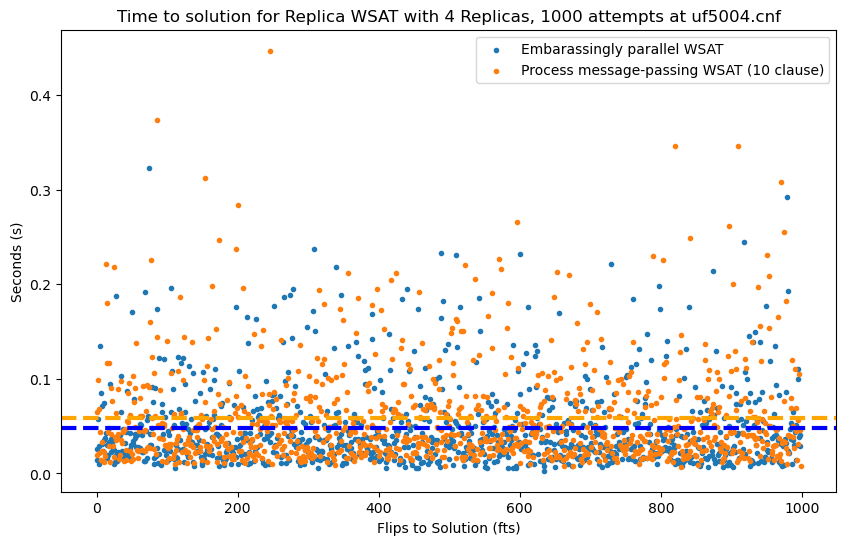

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(range(len(a_seconds)), a_seconds, marker='.', linestyle='-', label = "Embarassingly parallel WSAT")
plt.scatter(range(len(b_seconds)), b_seconds, marker='.', linestyle='-', label = "Process message-passing WSAT (10 clause)")
plt.title('Time to solution for Replica WSAT with 4 Replicas, 1000 attempts at uf5004.cnf')
plt.xlabel('Flips to Solution (fts)')
plt.ylabel('Seconds (s)')
plt.axhline(y=np.nanmean(a_seconds),   color = 'blue',
  linestyle = '--', 
  linewidth = 3)
plt.axhline(y=np.nanmean(b_seconds),   color = 'orange',
  linestyle = '--', 
  linewidth = 3)
plt.legend()    


In [201]:
import numpy as np
np.mean(a_seconds) - np.mean(b_seconds)

-0.010429659127447012

TODO:

REPLICA A1 Benchmarking (COMPARE PER HEURISTIC CHOSEN)